In [1]:
import glob
import imageio
import PIL
import time
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm_notebook, tnrange
from tqdm import tqdm 
import numpy
import os
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -uq "/content/drive/My Drive/Colab Notebooks/film.zip" 

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
IMG_SHAPE = (64, 64, 3)

In [4]:
def change_res(img):
  res = img.shape
  width = 64
  height = 64
  dim = (width, height)
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  resized =  numpy.asarray(resized)
  return resized

In [5]:
 import os
 arr = os.listdir('the.analog.club')
 image = []

 for name in tqdm(arr):
      img = imageio.imread("the.analog.club/"+name)
      img = change_res(img)
      flipped = tf.image.flip_left_right(img)
      updown = tf.image.flip_left_right(img)
      saturated = tf.image.random_saturation(img,5,10,2)
      image.append(img)
      image.append(numpy.array(saturated))
      image.append(numpy.array(flipped))
      image.append(numpy.array(updown))
 train_images = numpy.asarray(image) 

100%|██████████| 2432/2432 [01:10<00:00, 34.29it/s]


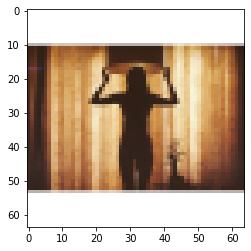

In [6]:
plt.imshow(train_images[20,:,:,:])

In [7]:
image[0].shape

(64, 64, 3)

In [8]:
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0],train_images.shape[1], train_images.shape[2], 3).astype('float32')
train_images = (train_images - 127.5) / 127.5

(9728, 64, 64, 3)


In [9]:
import cv2

def add_gaussian_noise(X_imgs):
    gaussian_noise_imgs = []
    row, col, _ = X_imgs[0].shape
    # Gaussian distribution parameters
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    
    for X_img in X_imgs:
        gaussian = numpy.random.random((row, col, 1)).astype(numpy.float32)
        gaussian = numpy.concatenate((gaussian, gaussian, gaussian), axis = 2)
        gaussian_img = cv2.addWeighted(X_img, 0.75, 0.25 * gaussian, 0.25, 0)
        gaussian_noise_imgs.append(gaussian_img)
    gaussian_noise_imgs = numpy.array(gaussian_noise_imgs, dtype = numpy.float32)
    return gaussian_noise_imgs
  
gaussian_noise_imgs = add_gaussian_noise(train_images)
train_images = numpy.vstack((train_images,gaussian_noise_imgs))

In [10]:
BUFFER_SIZE = 600
BATCH_SIZE = 300
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_images.shape[0])

19456


In [11]:
def upsample(filters, size,upsample = 0,apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  if upsample == 1:
    upstd = 1
    std = 2
  else:
    upstd = 2
    std = 1

  result = tf.keras.Sequential()
  result.add(layers.Conv2DTranspose(filters, size, strides=upstd,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  if upsample == 1:
    result.add(layers.UpSampling2D(size = std, interpolation='bilinear'))
  result.add(layers.BatchNormalization())

  if apply_dropout:
      result.add(layers.Dropout(0.2))

  result.add(layers.LeakyReLU())
  
  return result

In [12]:
def downsample(filters, size, std = 2, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)
  

  result = tf.keras.Sequential()
  result.add(layers.Conv2D(filters, size, strides=1, padding='same',
                             kernel_initializer=initializer, use_bias=False))
  result.add(layers.AveragePooling2D(std))
 
  if apply_batchnorm:
    result.add(layers.BatchNormalization())

  result.add(layers.LeakyReLU())

  return result

In [13]:
def upinc_block(x,filters)-> tf.Tensor:


    initializer = tf.random_normal_initializer(0., 0.02)
    
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x1 = upsample(filters,2)(x)

    x2 = upsample(filters,1,1)(x) 
    x2 = upsample(filters,4)(x2) 

    x3 = upsample(filters,1,1)(x)
    x3 = upsample(filters,2,1)(x3) 
    x3 = upsample(filters,4)(x3) 

    out = layers.Multiply()([x1,x2,x3])      
    
    return out

In [14]:
def incres_block(t,filters)-> tf.Tensor:

    initializer = tf.random_normal_initializer(0., 0.02)


    x = layers.BatchNormalization()(t)
    x = layers.LeakyReLU()(x)
  
    x1 = layers.Conv2D(filters,2,kernel_initializer=initializer,padding="same")(x)
    x2 = layers.Conv2D(filters,4,kernel_initializer=initializer,padding="same")(x)
            
    out = layers.Multiply()([x1,x2])  
    return out

In [15]:
def generator(noise_dim = 128):
              
    initializer = tf.random_normal_initializer(0., 0.02)
    noise = layers.Input(shape = noise_dim)
    n_nodes = 256*4*4
    
    x = layers.Dense(n_nodes,kernel_initializer=initializer)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((4,4,256))(x)

    x = upsample(256,4,upsample=1)(x)
    x = upsample(128,4,upsample=1)(x)
    x = upsample(64,4,upsample=1)(x)
    x = upsample(32,4,upsample=1)(x)

    x = layers.Conv2DTranspose(3,4,1,activation='tanh', padding= 'same',
                               kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs= noise, outputs=x,name="generator")
    


In [16]:
gen = generator()
gen.summary()
#tf.keras.utils.plot_model(gen, show_shapes=True, dpi=64)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              528384    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
sequential (Sequential)      (None, 8, 8, 256)         1049600   
_________________________________________________________________
sequential_1 (Sequential)    (None, 16, 16, 128)      

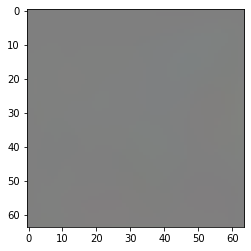

In [17]:
noise = tf.random.normal([1, 128], mean = 0.0, stddev = 1)
generated_image = gen(noise, training=False)
pp = numpy.asarray(generated_image)*127.5 + 127.5
plt.imshow(pp[0, :, :, :].astype(numpy.uint8), vmax = 255, vmin = 0)

In [18]:
def critic(inp_dim = (64,64,3)):
    initializer = tf.random_normal_initializer(0., 0.02)
    img = layers.Input(shape = inp_dim)

    # ENCODER

    x = downsample(64,4)(img)
    x = downsample(128,4)(x)
    x = downsample(256,4)(x)
    x = downsample(512,4)(x)
    x = layers.Flatten()(x)
  
    x = layers.Dense(1,activation = 'linear',kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs= img, outputs=x,name="discriminator")

In [27]:
disc = critic()
disc.summary()

#print(decision[0])

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 32, 32, 64)        3328      
_________________________________________________________________
sequential_9 (Sequential)    (None, 16, 16, 128)       131584    
_________________________________________________________________
sequential_10 (Sequential)   (None, 8, 8, 256)         525312    
_________________________________________________________________
sequential_11 (Sequential)   (None, 4, 4, 512)         2099200   
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)               

In [28]:
decision = disc(generated_image, training = False)
print(decision)

tf.Tensor([[-0.00028702]], shape=(1, 1), dtype=float32)


In [29]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # get the interplated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper.
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add gradient penalty to the discriminator loss
        # 6. Return generator and discriminator losses as a loss dictionary.

        # Train discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate discriminator loss using fake and real logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator now.
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [30]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))

In [ ]:
# Optimizer for both the networks
# learning_rate=0.0002, beta_1=0.5 are recommened
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions to be used for discrimiator
# This should be (fake_loss - real_loss)
# We will add the gradient penalty later to this loss function
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions to be used for generator
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Epochs to train
epochs = 20

# Callbacks
cbk = GANMonitor(num_img=3, latent_dim=128)

# Get the wgan model
wgan = WGAN(
    discriminator=disc,
    generator=gen,
    latent_dim=128,
    discriminator_extra_steps=3,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

Epoch 1/20
65/65 [==============================] - 94s 1s/step - d_loss: -139.3903 - g_loss: 81.6587
Epoch 2/20
65/65 [==============================] - 93s 1s/step - d_loss: -356.7415 - g_loss: 203.6835
Epoch 3/20
65/65 [==============================] - 93s 1s/step - d_loss: -637.2846 - g_loss: 351.1908
Epoch 4/20
65/65 [==============================] - 93s 1s/step - d_loss: -992.9430 - g_loss: 587.6195
Epoch 5/20
65/65 [==============================] - 93s 1s/step - d_loss: -1472.8645 - g_loss: 807.6219
Epoch 6/20
50/65 [======================>.......] - ETA: 21s - d_loss: -1837.2625 - g_loss: 1043.0774

In [ ]:
from IPython.display import Image, display

display(Image("generated_img_0_19.png"))
display(Image("generated_img_1_19.png"))
display(Image("generated_img_2_19.png"))